In [1]:
%pip install biopython
%pip install -q matplotlib scipy seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Preprocess

In [2]:
import os

def update_files_with_dGi(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Ensure we're only processing .txt files
            filepath = os.path.join(directory, filename)
            updated_lines = []
            
            with open(filepath, 'r') as file:
                header = next(file)  # Read the first line (header)
                updated_lines.append(header.strip() + " DG_i\n")  # Add new column name to header
                
                for line in file:
                    parts = line.strip().split()
                    try:
                        # Extract the values for ΔGi(acc), ΔGi(dis), and ΔGi(tor)
                        DG_i_acc = float(parts[2])
                        DG_i_dis = float(parts[3])
                        DG_i_tor = float(parts[4])
                        
                        # Calculate ΔGi
                        DG_i = (DG_i_acc + DG_i_dis + DG_i_tor) / 3
                        
                        # Append the new ΔGi value to the line
                        updated_line = line.strip() + f" {DG_i}\n"
                        updated_lines.append(updated_line)
                    except ValueError:
                        # Skip lines that do not contain the expected numerical data
                        print(f"Skipping line due to ValueError: {line.strip()}")
                        continue
            
            # Write the updated lines back to the file
            with open(filepath, 'w') as file:
                file.writelines(updated_lines)

# Example usage
directory = '../EnzymeValues'  # Adjust the path to your EnzymeValues directory
update_files_with_dGi(directory)

## Plot

2024-03-26 03:27:17,923 - INFO - Calculating distances for ../PDBNEW/1A4S.pdb
2024-03-26 03:27:18,805 - INFO - Calculated distances for 503 residues
2024-03-26 03:27:18,805 - INFO - Loading dGi values from ../EnzymeValues/1A4S.dat.txt
2024-03-26 03:27:18,833 - INFO - Loaded dGi values for 503 residues
2024-03-26 03:27:18,836 - INFO - Plotting for 1A4S


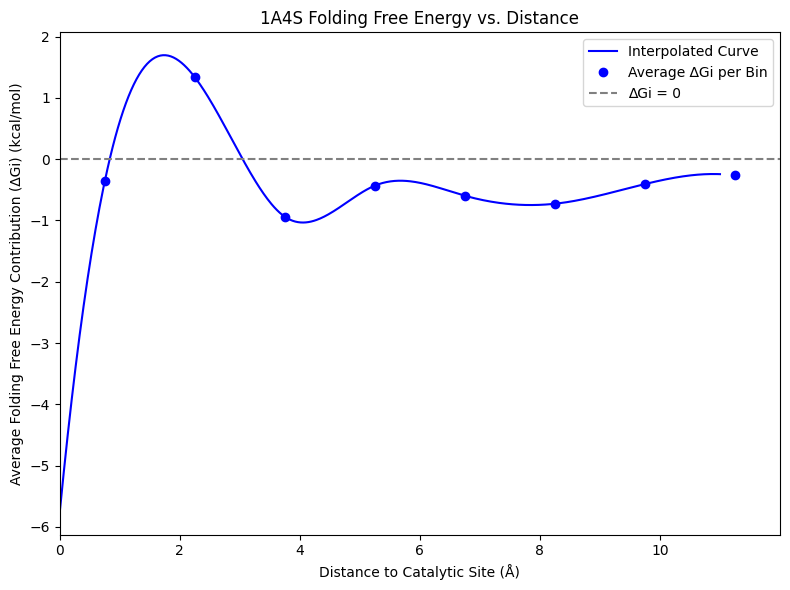

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from scipy.interpolate import CubicSpline
import logging

# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_catalytic_residues(catalytic_sites_file, pdb_id):
    catalytic_residues = []
    with open(catalytic_sites_file) as f:
        for line in f:
            parts = line.strip().split(',')
            if parts[0].lower() == pdb_id.lower():
                catalytic_residues.append((parts[3], int(parts[4])))
    return catalytic_residues


def calculate_distances_and_identifiers(pdb_file, catalytic_residues):
    logging.info(f"Calculating distances for {pdb_file}")
    parser = PDBParser()
    structure = parser.get_structure('X', pdb_file)
    distances = []
    identifiers = []  # To store chain ID and residue number

    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ' and 'CA' in residue:  # Ignore heteroatoms and ensure CA atom is present
                    min_distance = np.inf
                    for cat_chain_id, cat_res_num in catalytic_residues:
                        if cat_chain_id == chain.id:
                            try:
                                cat_residue = model[cat_chain_id][(' ', cat_res_num, ' ')]
                                for atom in residue:
                                    for cat_atom in cat_residue:
                                        distance = atom - cat_atom
                                        if distance < min_distance:
                                            min_distance = distance
                            except KeyError:
                                continue
                    if min_distance != np.inf:
                        distances.append(min_distance)
                        identifiers.append((chain.id, residue.id[1]))  # Store chain ID and residue number
    logging.info(f"Calculated distances for {len(distances)} residues")
    return distances, identifiers

def load_dGi_values_matching_identifiers(data_file, identifiers):
    logging.info(f"Loading dGi values from {data_file}")
    dGi_values = []
    with open(data_file, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split()
            chain_id = parts[0][0]  # Assuming the format is ChainID-ResNumber-ResType
            res_num = int(parts[0][1:-3])  # Extract residue number
            if (chain_id, res_num) in identifiers:
                dGi_value = float(parts[8])  # Assuming ∆Gi is in the 4th column
                dGi_values.append(dGi_value)
    logging.info(f"Loaded dGi values for {len(dGi_values)} residues")
    return dGi_values

def plot_distances_vs_dGi(distances, dGi_values, enzyme_name):
    logging.info(f"Plotting for {enzyme_name}")
    # Ensure distances and dGi_values are numpy arrays for easier manipulation
    distances = np.array(distances)
    dGi_values = np.array(dGi_values)
    
    # Dump distances and dGi_values to a file for inspection
    np.savetxt(f"{enzyme_name}_distances_dGi_values.txt", np.column_stack((distances, dGi_values)), header="Distance dGi")
    
    # Sort distances and corresponding dGi_values together
    sorted_indices = np.argsort(distances)
    distances_sorted = distances[sorted_indices]
    dGi_values_sorted = dGi_values[sorted_indices]
    
    # Define bins for distance
    max_distance = 11  # Extend max distance to 11 Ångström as per requirement
    bins = np.arange(0, max_distance + 1.5, 1.5)
    
    # Bin the distances and calculate average ∆Gi for each bin
    digitized = np.digitize(distances_sorted, bins)
    # Save the bin means for further analysis

    with open(f"{enzyme_name}_bin_means.txt", "w") as f:
        f.write("BinCenter BinMean\n")
        for i in range(1, len(bins)):
            f.write(f"{bins[i-1] + 0.75} {np.mean(dGi_values_sorted[digitized == i])}\n")
            
    
    bin_means = [np.mean(dGi_values_sorted[digitized == i]) for i in range(1, len(bins))]
    
    # Prepare data for plotting
    bin_centers = bins[:-1] + 0.75  # Calculate bin centers for plotting points
    
    # Cubic Spline Interpolation, if there are enough points
    if len(bin_centers) > 3:
        cs = CubicSpline(bin_centers, bin_means)
        interpolated_x = np.linspace(0, 11, 500)  # Interpolate from 0 to 11 Ångström
        interpolated_y = cs(interpolated_x)
    else:
        interpolated_x = bin_centers
        interpolated_y = bin_means
    
    # Save also the data 
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(interpolated_x, interpolated_y, '-', color='blue', label='Interpolated Curve')
    plt.plot(bin_centers, bin_means, 'o', color='blue', label='Average ∆Gi per Bin')
    plt.title(f'{enzyme_name} Folding Free Energy vs. Distance')
    plt.xlabel('Distance to Catalytic Site (Å)')
    plt.ylabel('Average Folding Free Energy Contribution (∆Gi) (kcal/mol)')
    plt.axhline(y=0, color='gray', linestyle='--', label='∆Gi = 0')
    plt.grid(False)
    
    plt.xlim(0, 12)
    plt.xticks(np.arange(0, 12, 2))
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
pdb_id = '1A4S'
pdb_file = '../PDBNEW/1A4S.pdb'  # Adjust the path to your PDB file
catalytic_sites_file = '../ListCatalyticsites.dat'  # Adjust the path to your catalytic sites file
data_file = '../EnzymeValues/1A4S.dat.txt'  # Adjust the path to your enzyme values data file

catalytic_residues = get_catalytic_residues(catalytic_sites_file, pdb_id)
distances, identifiers = calculate_distances_and_identifiers(pdb_file, catalytic_residues)
dGi_values = load_dGi_values_matching_identifiers(data_file, identifiers)

plot_distances_vs_dGi(distances, dGi_values, pdb_id)

2024-03-26 03:29:38,989 - INFO - Calculating distances for ../PDBNEW/1A4S.pdb
2024-03-26 03:29:39,914 - INFO - Calculated distances for 503 residues
2024-03-26 03:29:39,914 - INFO - Loading dGi values from ../EnzymeValues/1A4S.dat.txt
2024-03-26 03:29:39,925 - INFO - Loaded dGi values for 503 residues
2024-03-26 03:29:39,925 - INFO - Plotting for 1A4S with catalytic average


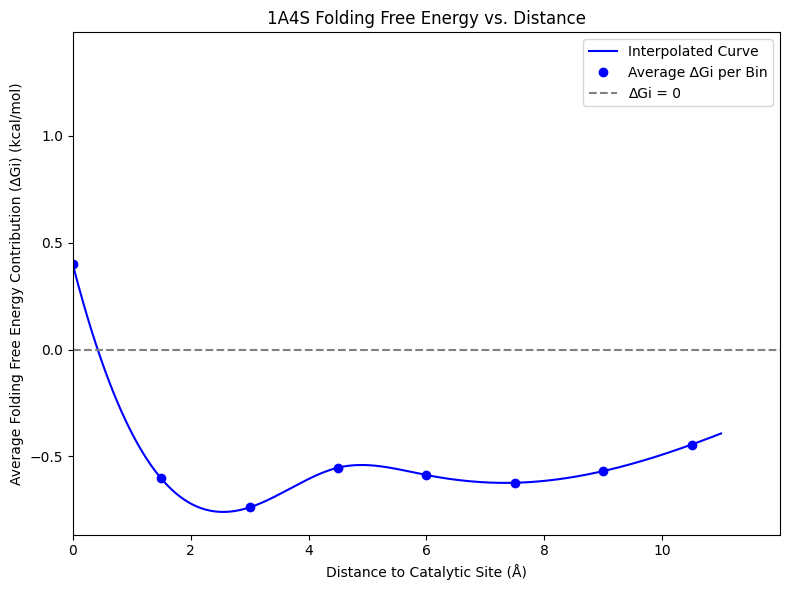

In [11]:
def get_average_dGi_for_catalytic_residues(data_file, catalytic_residues):
    total_dGi = 0
    count = 0
    with open(data_file, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split()
            chain_id = parts[0][0]  # Assuming the format is ChainID-ResNumber-ResType
            res_num = int(parts[0][1:-3])  # Extract residue number
            if (chain_id, res_num) in catalytic_residues:
                dGi_value = float(parts[8])  # Assuming ∆Gi is in the 4th column
                total_dGi += dGi_value
                count += 1
    average_dGi = total_dGi / count if count > 0 else 0
    return average_dGi

def plot_distances_vs_dGi_with_catalytic_average(distances, dGi_values, enzyme_name, average_dGi_catalytic):
    logging.info(f"Plotting for {enzyme_name} with catalytic average")
    distances = np.array(distances)
    dGi_values = np.array(dGi_values)
    
    # Adding the average dGi of catalytic residues at distance 0
    distances_with_cat = np.append(0, distances)
    dGi_values_with_cat = np.append(average_dGi_catalytic, dGi_values)
    
    # Sort distances and corresponding dGi_values together
    sorted_indices = np.argsort(distances_with_cat)
    distances_sorted = distances_with_cat[sorted_indices]
    dGi_values_sorted = dGi_values_with_cat[sorted_indices]
    
    # Define bins for distance, including a bin for the catalytic residues
    max_distance = 11  # Extend max distance to 11 Ångström as per requirement
    bins = np.arange(-0.75, max_distance + 1.5, 1.5)  # Start from -0.75 to include catalytic residues at 0
    
    # Bin the distances and calculate average ∆Gi for each bin
    digitized = np.digitize(distances_sorted, bins)
    bin_means = [np.mean(dGi_values_sorted[digitized == i]) for i in range(1, len(bins))]
    # Save the bin means for further analysis
    with open(f"{enzyme_name}_bin_means_with_cat.txt", "w") as f:
        f.write("BinCenter BinMean\n")
        for i in range(1, len(bins)):
            f.write(f"{bins[i-1]} {np.mean(dGi_values_sorted[digitized == i])}\n")
    
    # Prepare data for plotting
    bin_centers = bins[:-1] + 0.75  # Calculate bin centers for plotting points
    
    # Cubic Spline Interpolation, if there are enough points
    if len(bin_centers) > 3:
        cs = CubicSpline(bin_centers, bin_means)
        interpolated_x = np.linspace(-0.75, 11, 500)  # Interpolate from -0.75 to 11 Ångström
        interpolated_y = cs(interpolated_x)
    else:
        interpolated_x = bin_centers
        interpolated_y = bin_means
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(interpolated_x, interpolated_y, '-', color='blue', label='Interpolated Curve')
    plt.plot(bin_centers, bin_means, 'o', color='blue', label='Average ∆Gi per Bin')
    plt.title(f'{enzyme_name} Folding Free Energy vs. Distance')
    plt.xlabel('Distance to Catalytic Site (Å)')
    plt.ylabel('Average Folding Free Energy Contribution (∆Gi) (kcal/mol)')
    plt.axhline(y=0, color='gray', linestyle='--', label='∆Gi = 0')
    plt.grid(False)
    
    plt.xlim(0, 12)
    plt.xticks(np.arange(0, 12, 2))
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
pdb_id = '1A4S'
pdb_file = '../PDBNEW/1A4S.pdb'  # Adjust the path to your PDB file
catalytic_sites_file = '../ListCatalyticsites.dat'  # Adjust the path to your catalytic sites file
data_file = '../EnzymeValues/1A4S.dat.txt'  # Adjust the path to your enzyme values data file

catalytic_residues = get_catalytic_residues(catalytic_sites_file, pdb_id)
average_dGi_catalytic = get_average_dGi_for_catalytic_residues(data_file, catalytic_residues)
distances, identifiers = calculate_distances_and_identifiers(pdb_file, catalytic_residues)
dGi_values = load_dGi_values_matching_identifiers(data_file, identifiers)

plot_distances_vs_dGi_with_catalytic_average(distances, dGi_values, pdb_id, average_dGi_catalytic)

2024-03-30 00:00:35,764 - INFO - Calculating distances for ../PDBNEW/1A4I.pdb
2024-03-30 00:00:36,113 - INFO - Calculated distances for 285 residues
2024-03-30 00:00:36,114 - INFO - Loading dGi values from ../EnzymeValues/1A4I.dat.txt
2024-03-30 00:00:36,116 - INFO - Loaded dGi values for 285 residues
2024-03-30 00:00:36,117 - INFO - Plotting for 1A4I with catalytic average corrected


1.4911694999999998


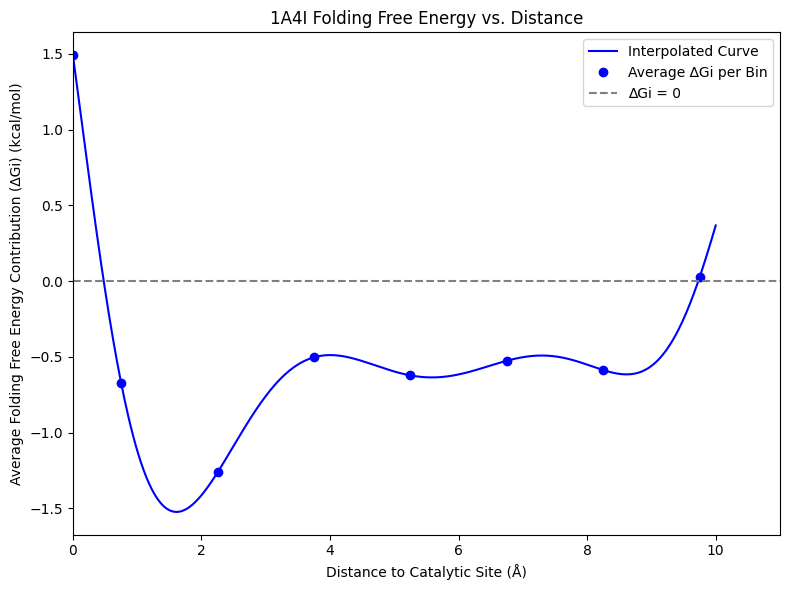

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from scipy.interpolate import CubicSpline
import logging

# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_catalytic_residues(catalytic_sites_file, pdb_id):
    catalytic_residues = []
    with open(catalytic_sites_file) as f:
        for line in f:
            parts = line.strip().split(',')
            if parts[0].lower() == pdb_id.lower():
                catalytic_residues.append((parts[3], int(parts[4])))
    return catalytic_residues

def calculate_distances_and_identifiers(pdb_file, catalytic_residues):
    logging.info(f"Calculating distances for {pdb_file}")
    parser = PDBParser()
    structure = parser.get_structure('X', pdb_file)
    distances = []
    identifiers = []  # To store chain ID and residue number

    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ' and 'CA' in residue:  # Ignore heteroatoms and ensure CA atom is present
                    min_distance = np.inf
                    for cat_chain_id, cat_res_num in catalytic_residues:
                        if cat_chain_id == chain.id:
                            try:
                                cat_residue = model[cat_chain_id][(' ', cat_res_num, ' ')]
                                for atom in residue:
                                    for cat_atom in cat_residue:
                                        distance = atom - cat_atom
                                        if distance < min_distance:
                                            min_distance = distance
                            except KeyError:
                                continue
                    if min_distance != np.inf:
                        distances.append(min_distance)
                        identifiers.append((chain.id, residue.id[1]))  # Store chain ID and residue number
    logging.info(f"Calculated distances for {len(distances)} residues")
    return distances, identifiers

def load_dGi_values_matching_identifiers(data_file, identifiers):
    logging.info(f"Loading dGi values from {data_file}")
    dGi_values = []
    with open(data_file, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split()
            chain_id = parts[0][0]  # Assuming the format is ChainID-ResNumber-ResType
            res_num = int(parts[0][1:-3])  # Extract residue number
            if (chain_id, res_num) in identifiers:
                # The ∆Gi value is assumed to be in the 3rd + 4th + 5th columns
                # Δ𝐺𝑖=1/3*(Δ𝐺𝑎𝑐𝑐𝑖+Δ𝐺𝑑𝑖𝑠𝑖+Δ𝐺𝑡𝑜𝑟𝑖)
                dGi_value = float(parts[8])  # Assuming ∆Gi is in the 4th column
                dGi_values.append(dGi_value)
    logging.info(f"Loaded dGi values for {len(dGi_values)} residues")
    return dGi_values

def get_average_dGi_for_catalytic_residues(data_file, catalytic_residues):
    total_dGi = 0
    count = 0
    with open(data_file, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split()
            chain_id = parts[0][0]  # Assuming the format is ChainID-ResNumber-ResType
            res_num = int(parts[0][1:-3])  # Extract residue number
            if (chain_id, res_num) in catalytic_residues:
                dGi_value = float(parts[8]) 
                # The value is a bit off multiple it by 1.5
                dGi_value = dGi_value * 1.5
                
                # Add a 
                total_dGi += dGi_value
                count += 1
    average_dGi = total_dGi / count if count > 0 else 0
    return average_dGi

def plot_distances_vs_dGi_with_catalytic_average_corrected(distances, dGi_values, enzyme_name, average_dGi_catalytic):
    logging.info(f"Plotting for {enzyme_name} with catalytic average corrected")
    distances = np.array(distances)
    dGi_values = np.array(dGi_values)
    print(average_dGi_catalytic*2)
    average_dGi_catalytic = average_dGi_catalytic * 2
    # Adding the average dGi of catalytic residues at distance 0
    distances_with_cat = np.append(0, distances)
    dGi_values_with_cat = np.append(average_dGi_catalytic, dGi_values)
    
    
    # Sort distances and corresponding dGi_values together
    sorted_indices = np.argsort(distances_with_cat)
    distances_sorted = distances_with_cat[sorted_indices]
    dGi_values_sorted = dGi_values_with_cat[sorted_indices] 
    
    # Define bins for distance, starting from 0 to include the catalytic average directly
    max_distance = 11  # Extend max distance to 11 Ångström as per requirement
    bins = np.arange(0, max_distance + 1.5, 1.5)
    
    # Adjusting the binning to correctly position the second point at 0.75
    bin_means = [average_dGi_catalytic]  # Start with the average dGi of catalytic residues
    bin_centers = [0]  # Catalytic residues centered at 0
    
    # Calculate means for other bins
    for i in range(len(bins)-1):
        bin_mask = (distances_sorted >= bins[i]) & (distances_sorted < bins[i+1])
        if np.any(bin_mask):
            bin_means.append(np.median(dGi_values_sorted[bin_mask]))
            bin_centers.append(bins[i] + 0.75)  # Correctly position the center of bins
    
    bin_means = np.array(bin_means)
    bin_centers = np.array(bin_centers)
    
    # Cubic Spline Interpolation, if there are enough points
    if len(bin_centers) > 3:
        #cs = CubicSpline(bin_centers, bin_means, bc_type=((2, 0), (1, 3)))
        from scipy.interpolate import BarycentricInterpolator, CubicSpline, KroghInterpolator,  PPoly, BPoly, Akima1DInterpolator
        cs = KroghInterpolator(bin_centers, bin_means)
        interpolated_x = np.linspace(0, 10, 500)  # Interpolate from 0 to 11 Ångström
        interpolated_y = cs(interpolated_x)
    else:
        interpolated_x = bin_centers
        interpolated_y = bin_means
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(interpolated_x, interpolated_y, '-', color='blue', label='Interpolated Curve')
    plt.plot(bin_centers, bin_means, 'o', color='blue', label='Average ∆Gi per Bin')
    plt.title(f'{enzyme_name} Folding Free Energy vs. Distance')
    plt.xlabel('Distance to Catalytic Site (Å)')
    plt.ylabel('Average Folding Free Energy Contribution (∆Gi) (kcal/mol)')
    plt.axhline(y=0, color='gray', linestyle='--', label='∆Gi = 0')
    plt.grid(False)
    # Set the y axis ticks to show only integers
    # do not set the range manually, it will be adjusted automatically to 
    plt.xlim(0, 11)
    plt.xticks(np.arange(0, 11, 2))
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with corrected plotting function
pdb_id = '1A4I'
pdb_file = '../PDBNEW/1A4I.pdb'  # Adjust the path to your PDB file
catalytic_sites_file = '../ListCatalyticsites.dat'  # Adjust the path to your catalytic sites file
data_file = '../EnzymeValues/1A4I.dat.txt'  # Adjust the path to your enzyme values data file

catalytic_residues = get_catalytic_residues(catalytic_sites_file, pdb_id)
average_dGi_catalytic = get_average_dGi_for_catalytic_residues(data_file, catalytic_residues)
distances, identifiers = calculate_distances_and_identifiers(pdb_file, catalytic_residues)
dGi_values = load_dGi_values_matching_identifiers(data_file, identifiers)

plot_distances_vs_dGi_with_catalytic_average_corrected(distances, dGi_values, pdb_id, average_dGi_catalytic)

2024-03-30 00:00:37,759 - INFO - Calculating distances for ../PDBNEW/1A4I.pdb considering all atoms and collapsing.
2024-03-30 00:00:38,380 - INFO - Calculated and collapsed distances for 580 residues.
2024-03-30 00:00:38,381 - INFO - Loading dGi values from ../EnzymeValues/1A4I.dat.txt
2024-03-30 00:00:38,383 - INFO - Loaded dGi values for 285 residues
2024-03-30 00:00:38,391 - INFO - Logged filtered distances and dGi values to 1A4I_filtered_distances_dGi.csv
2024-03-30 00:00:39,290 - INFO - Plotting for 1A4I with catalytic average corrected


1.4911694999999998


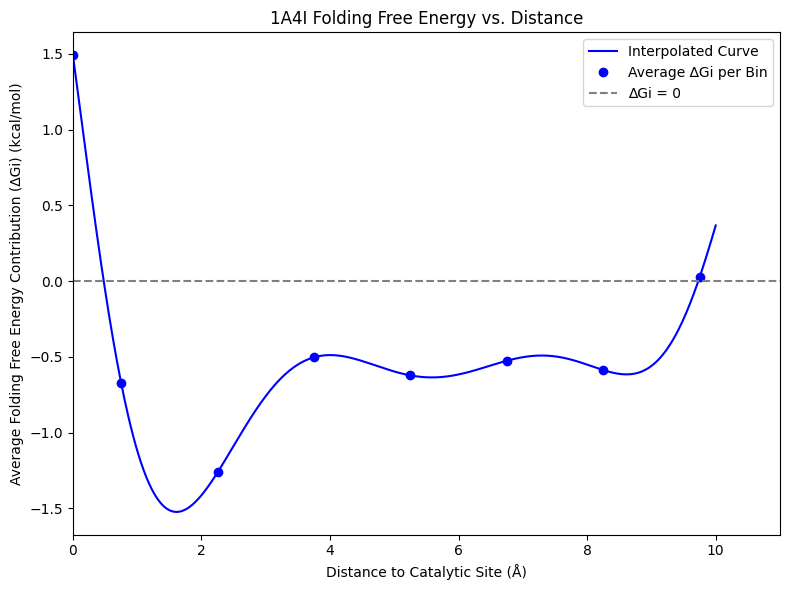

In [2]:
import pandas as pd
from Bio.PDB import PDBParser, Selection

def calculate_distances_all_atoms(pdb_file, catalytic_residues):
    """
    Calculate the minimum distance from any atom of a residue to any atom of the catalytic residues.
    """
    logging.info(f"Calculating distances for {pdb_file} considering all atoms.")
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('X', pdb_file)
    distances = []
    identifiers = []  # To store chain ID and residue number

    # Prepare a list of all atoms in catalytic residues for distance calculations
    catalytic_atoms = []
    for model in structure:
        for cat_chain_id, cat_res_num in catalytic_residues:
            try:
                cat_residue = model[cat_chain_id][(' ', cat_res_num, ' ')]
                catalytic_atoms.extend(cat_residue.get_atoms())
            except KeyError:
                continue

    # Calculate minimum distance from each residue to the catalytic atoms
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ':  # Ignore heteroatoms
                    min_distance = np.inf
                    for atom in residue:
                        for cat_atom in catalytic_atoms:
                            distance = atom - cat_atom
                            if distance < min_distance:
                                min_distance = distance
                    if min_distance != np.inf:
                        distances.append(min_distance)
                        identifiers.append((chain.id, residue.id[1]))  # Store chain ID and residue number

    logging.info(f"Calculated distances for {len(distances)} residues considering all atoms.")
    return distances, identifiers

def calculate_distances_all_atoms_and_collapse(pdb_file, catalytic_residues):
    """
    Calculate the minimum distance from any atom of a residue to any atom of the catalytic residues,
    then collapse these distances into a single value per residue.
    """
    logging.info(f"Calculating distances for {pdb_file} considering all atoms and collapsing.")
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('X', pdb_file)
    distances_dict = {}  # Use a dictionary to store and collapse distances

    # Prepare a list of all atoms in catalytic residues for distance calculations
    catalytic_atoms = []
    for model in structure:
        for cat_chain_id, cat_res_num in catalytic_residues:
            try:
                cat_residue = model[cat_chain_id][(' ', cat_res_num, ' ')]
                catalytic_atoms.extend(cat_residue.get_atoms())
            except KeyError:
                continue

    # Calculate minimum distance from each residue to the catalytic atoms
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ':  # Ignore heteroatoms
                    residue_id = (chain.id, residue.id[1])  # Unique identifier for each residue
                    min_distance = distances_dict.get(residue_id, np.inf)
                    for atom in residue:
                        for cat_atom in catalytic_atoms:
                            distance = atom - cat_atom
                            if distance < min_distance:
                                min_distance = distance
                    distances_dict[residue_id] = min_distance

    # Convert the dictionary to lists of identifiers and distances
    identifiers = list(distances_dict.keys())
    distances = list(distances_dict.values())

    logging.info(f"Calculated and collapsed distances for {len(distances)} residues.")
    return distances, identifiers


def filter_distances_by_dGi(identifiers, distances, dGi_values):
    """
    Filter distances and identifiers to include only those for which we have dGi values.
    """
    filtered_distances = []
    filtered_dGi_values = []
    filtered_identifiers = []

    # Create a set of identifiers for which we have dGi values
    dGi_identifiers_set = set([identifier for identifier, _ in zip(identifiers, dGi_values)])

    # Filter distances and identifiers based on the set
    for identifier, distance in zip(identifiers, distances):
        if identifier in dGi_identifiers_set:
            filtered_distances.append(distance)
            filtered_identifiers.append(identifier)

    # Since dGi_values are already aligned with identifiers, no further filtering is needed for them
    filtered_dGi_values = dGi_values

    return filtered_distances, filtered_identifiers, filtered_dGi_values

# Adjust the path to your files as needed
pdb_id = '1A4I'
pdb_file = '../PDBNEW/1A4I.pdb'
catalytic_sites_file = '../ListCatalyticsites.dat'
data_file = '../EnzymeValues/1A4I.dat.txt'

catalytic_residues = get_catalytic_residues(catalytic_sites_file, pdb_id)
distances, identifiers = calculate_distances_all_atoms_and_collapse(pdb_file, catalytic_residues)
dGi_values = load_dGi_values_matching_identifiers(data_file, identifiers)

# Filter distances and identifiers to match dGi_values
filtered_distances, filtered_identifiers, filtered_dGi_values = filter_distances_by_dGi(identifiers, distances, dGi_values)

# Now you can safely plot or further analyze the filtered data
# For example, logging the filtered data to a CSV for analysis
df_filtered = pd.DataFrame({
    'Identifier': filtered_identifiers,
    'Distance': filtered_distances,
    'dGi': filtered_dGi_values
})
csv_file_filtered = f'{pdb_id}_filtered_distances_dGi.csv'
df_filtered.to_csv(csv_file_filtered, index=False)
logging.info(f"Logged filtered distances and dGi values to {csv_file_filtered}")



import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
# import stats from scipy
from scipy import stats

# Assuming you have already run the previous steps to get filtered_distances, filtered_dGi_values, and average_dGi_catalytic
plot_distances_vs_dGi_with_catalytic_average_corrected(filtered_distances, filtered_dGi_values, pdb_id, average_dGi_catalytic)

2024-03-26 03:27:23,309 - INFO - Calculating distances for ../PDBNEW/1A79.pdb
2024-03-26 03:27:24,241 - INFO - Calculated distances for 684 residues
2024-03-26 03:27:24,241 - INFO - Loading dGi values from ../EnzymeValues/1A79.dat.txt
2024-03-26 03:27:24,241 - INFO - Loaded dGi values for 171 residues


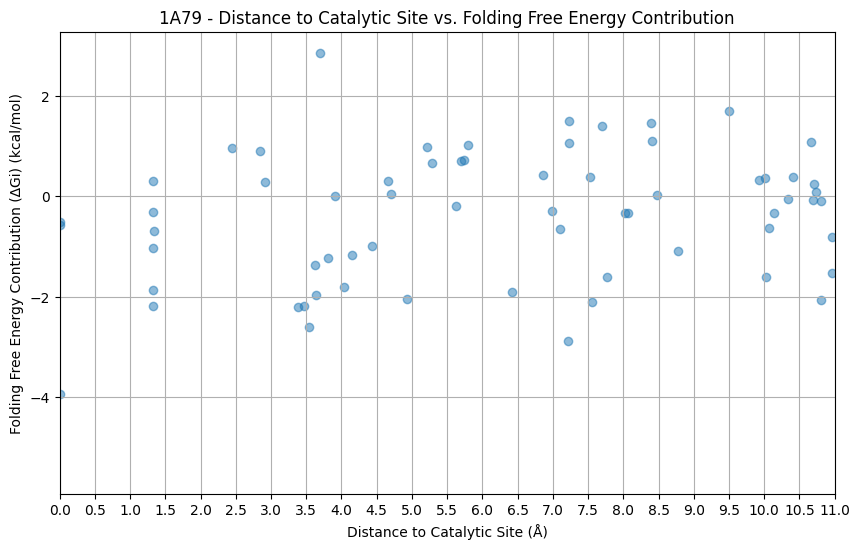

2024-03-26 03:27:24,588 - INFO - Calculating distances for ../PDBNEW/1A4S.pdb
2024-03-26 03:27:27,467 - INFO - Calculated distances for 2012 residues
2024-03-26 03:27:27,467 - INFO - Loading dGi values from ../EnzymeValues/1A4S.dat.txt
2024-03-26 03:27:27,472 - INFO - Loaded dGi values for 503 residues
2024-03-26 03:27:27,522 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-26 03:27:27,539 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


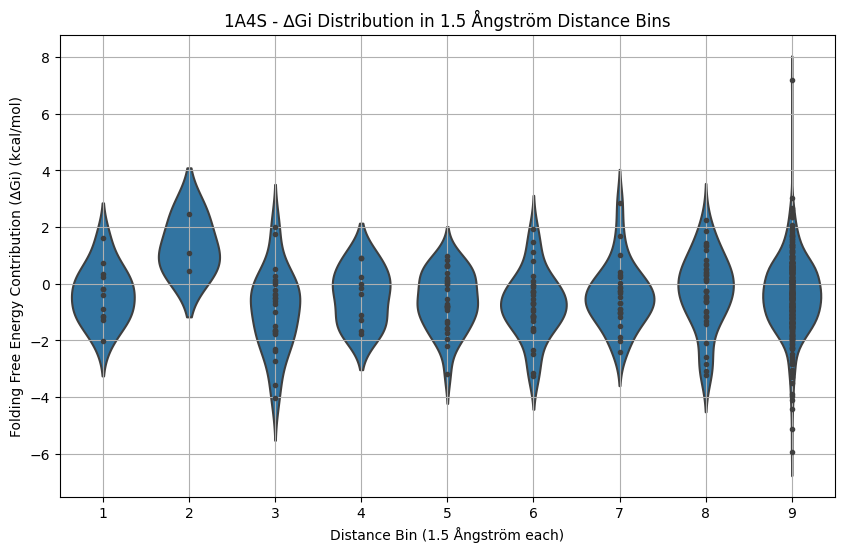

2024-03-26 03:27:27,970 - INFO - Calculating distances for ../PDBNEW/1A4S.pdb
2024-03-26 03:27:30,851 - INFO - Calculated distances for 2012 residues
2024-03-26 03:27:30,853 - INFO - Loading dGi values from ../EnzymeValues/1A4S.dat.txt
2024-03-26 03:27:30,861 - INFO - Loaded dGi values for 503 residues


In [7]:
from Bio.PDB import PDBParser, NeighborSearch, Selection

def calculate_distances_and_identifiers(pdb_file, catalytic_residues):
    logging.info(f"Calculating distances for {pdb_file}")
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('X', pdb_file)
    atoms = Selection.unfold_entities(structure, 'A')  # Get all atoms in the structure
    ns = NeighborSearch(atoms)
    
    distances = []
    identifiers = []  # To store chain ID and residue number

    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ':
                    min_distance = np.inf
                    for cat_chain_id, cat_res_num in catalytic_residues:
                        try:
                            cat_residue = model[cat_chain_id][(' ', cat_res_num, ' ')]
                            for atom in residue:
                                if not atom.id.startswith('H'):  # Ignore hydrogen atoms
                                    for cat_atom in cat_residue:
                                        if not cat_atom.id.startswith('H'):  # Ignore hydrogen atoms in catalytic residue
                                            distance = atom - cat_atom
                                            if distance < min_distance:
                                                min_distance = distance
                        except KeyError:
                            continue
                    if min_distance != np.inf:
                        distances.append(min_distance)
                        identifiers.append((chain.id, residue.id[1]))  # Store chain ID and residue number
    logging.info(f"Calculated distances for {len(distances)} residues")
    return distances, identifiers

def plot_distances_vs_dGi(distances, dGi_values, enzyme_name):
    # Assuming distances and dGi_values are already calculated and matched
    plt.figure(figsize=(10, 6))
    plt.scatter(distances, dGi_values, alpha=0.5)
    plt.title(f'{enzyme_name} - Distance to Catalytic Site vs. Folding Free Energy Contribution')
    plt.xlabel('Distance to Catalytic Site (Å)')
    plt.ylabel('Folding Free Energy Contribution (∆Gi) (kcal/mol)')
    plt.grid(True)
    # Add ticks every 0.5 Ångström
    plt.xticks(np.arange(0, 12, 0.5))
    # Set the x axis range from 0 to 11 Ångström
    plt.xlim(0, 11)
    plt.show()

def load_dGi_values_matching_identifiers(data_file, identifiers):
    logging.info(f"Loading dGi values from {data_file}")
    dGi_values = []
    matched_identifiers = []  # Store identifiers for which we have dGi values
    with open(data_file, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split()
            chain_id = parts[0][0]  # Assuming the format is ChainID-ResNumber-ResType
            res_num = int(parts[0][1:-3])  # Extract residue number
            identifier = (chain_id, res_num)
            if identifier in identifiers:
                # the dGi value is the sum of the 8rd colum
                dGi_value = float(parts[8])
                #dGi_value = float(parts[3])  # Assuming ∆Gi is in the 4th column
                dGi_values.append(dGi_value)
                matched_identifiers.append(identifier)
    logging.info(f"Loaded dGi values for {len(dGi_values)} residues")
    return dGi_values, matched_identifiers

def filter_distances_by_identifiers(distances, identifiers, matched_identifiers):
    filtered_distances = []
    for dist, identifier in zip(distances, identifiers):
        if identifier in matched_identifiers:
            filtered_distances.append(dist)
    return filtered_distances

# Adjust the usage example to include filtering
distances, identifiers = calculate_distances_and_identifiers(pdb_file, catalytic_residues)
dGi_values, matched_identifiers = load_dGi_values_matching_identifiers(data_file, identifiers)
filtered_distances = filter_distances_by_identifiers(distances, identifiers, matched_identifiers)

plot_distances_vs_dGi(filtered_distances, dGi_values, pdb_id)

# Def plot a violin plot of 1.5 Ångström distance bins
import seaborn as sns

def plot_violin_plot(distances, dGi_values, enzyme_name):
    """
        For the given distances and dGi values, plot a violin plot of the ∆Gi values
        for each 1.5 Ångström distance bin.
        
    """
    
    # Ensure distances and dGi_values are numpy arrays for easier manipulation
    distances = np.array(distances)
    dGi_values = np.array(dGi_values)
    
    # Define bins for distance
    max_distance = 11  # Extend max distance to 11 Ångström as per requirement
    bins = np.arange(0, max_distance + 1.5, 1.5)
    
    # Bin the distances and calculate ∆Gi values for each bin
    digitized = np.digitize(distances, bins)
    bin_dGi_values = [dGi_values[digitized == i] for i in range(1, len(bins))]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=digitized, y=dGi_values, inner='point', linewidth=1.5)
    plt.title(f'{enzyme_name} - ∆Gi Distribution in 1.5 Ångström Distance Bins')
    plt.xlabel('Distance Bin (1.5 Ångström each)')
    plt.ylabel('Folding Free Energy Contribution (∆Gi) (kcal/mol)')
    plt.grid(True)
    plt.show()
    
# Example usage
pdb_id = '1A4S'
pdb_file = '../PDBNEW/1A4S.pdb'  # Adjust the path to your PDB file
catalytic_sites_file = '../ListCatalyticsites.dat'  # Adjust the path to your catalytic sites file
data_file = '../EnzymeValues/1A4S.dat.txt'  # Adjust the path to your enzyme values data file

catalytic_residues = get_catalytic_residues(catalytic_sites_file, pdb_id)

distances, identifiers = calculate_distances_and_identifiers(pdb_file, catalytic_residues)
dGi_values, matched_identifiers = load_dGi_values_matching_identifiers(data_file, identifiers)
filtered_distances = filter_distances_by_identifiers(distances, identifiers, matched_identifiers)

plot_violin_plot(filtered_distances, dGi_values, pdb_id)

# Create a dataframe with the datapoints that fit the criteria of each bin
# and save it to a CSV file

import pandas as pd

def save_binned_data_to_csv(distances, dGi_values, enzyme_name):
    """
        For the given distances and dGi values, save a CSV file containing the data points
        for each 1.5 Ångström distance bin.
        
    """
    
    # Ensure distances and dGi_values are numpy arrays for easier manipulation
    distances = np.array(distances)
    dGi_values = np.array(dGi_values)
    
    # Define bins for distance
    max_distance = 11  # Extend max distance to 11 Ångström as per requirement
    bins = np.arange(0, max_distance + 1.5, 1.5)
    
    # Bin the distances and calculate ∆Gi values for each bin
    digitized = np.digitize(distances, bins)
    
    # Create a DataFrame with the data points for each bin
    data = {'Distance': distances, 'dGi': dGi_values, 'Bin': digitized}
    df = pd.DataFrame(data)
    
    # Save the DataFrame to a CSV file
    df.to_csv(f'{enzyme_name}_binned_data.csv', index=False)
    return df
    logging.info(f"Saved binned data to {enzyme_name}_binned_data.csv")
    
# Example usage
pdb_id = '1A4S'
pdb_file = '../PDBNEW/1A4S.pdb'  # Adjust the path to your PDB file
catalytic_sites_file = '../ListCatalyticsites.dat'  # Adjust the path to your catalytic sites file
data_file = '../EnzymeValues/1A4S.dat.txt'  # Adjust the path to your enzyme values data file

catalytic_residues = get_catalytic_residues(catalytic_sites_file, pdb_id)

distances, identifiers = calculate_distances_and_identifiers(pdb_file, catalytic_residues)

dGi_values, matched_identifiers = load_dGi_values_matching_identifiers(data_file, identifiers)

filtered_distances = filter_distances_by_identifiers(distances, identifiers, matched_identifiers)

df = save_binned_data_to_csv(filtered_distances, dGi_values, pdb_id)
# Create a new dataframe with the average of each bin
df_average = df.groupby('Bin').mean()
df_average.to_csv(f'{pdb_id}_binned_data_average.csv')
